In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import os
from datetime import datetime
from math import sqrt

In [2]:
# --------- VAE PARAMETERS --------------

stroke_dim = 5

# decoder 
M = 10 # number of normal distributions for output 
T = 0.1# temperature parameter
sqrtT = sqrt(T) # saves computation
dec_hidden_dim = 2048 # dimension of cell and hidden states

# encoder
enc_hidden_dim = 2048 # dimension of cell and hidden states

# --------- TRAINING PARAMETERS ----------

lr = 2e-3 # Used to be 2e-3 but got NaN gradients
batch_size = 2 # batch_size >= 1, used to be 128
latent_dim = 128 # Used to be 128
n_epochs = 1500 # Used to be 150
w_kl = 0.7 # weight for loss calculation, can be tuned if needed
anneal_loss = False # True if train using annealed kl loss, False otherwise
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained = False
# --------- DATA LOADING -----------------

# Get file path for one class of sketches
data_path = '/kaggle/input/tinyquickdraw/sketches/sketches/apple.npz'
# data_path = '/kaggle/input/tinyquickdraw/sketches/sketches/ambulance.npz'
#for debugging purposes, comment the above line and decomment the below line
# data_path = 'python/ambulance.npz' # ambulance.npz is stored alongside the files on my computer, feel free to change
# data_path = 'ambulance.npz'
dataset = np.load(data_path, encoding='latin1', allow_pickle=True)
data = dataset["train"]
Nmax = max([len(i) for i in data])

In [3]:
def encode_pen_state(sketch,length):
    """
    One-hot encode pen state by adding additional columns for pen up and end of stroke.
    
    Parameters: 
        sketch (ndarray): n*3 array with format (x,y,p1), representing sketch data
        
    Returns: 
        ndarray: n*5 array with format (x,y,p1,p2,p3), where p2 = 1-p1 and p3 is 1 at 
        end of the sketch, 0 otherwise.
    """
    
    shape = sketch.shape
    pen_up = (np.ones(shape[0]) - sketch[:,2]).reshape(shape[0],1)
    end_stroke = np.zeros((shape[0],1))
    end_stroke[length:] = 1 
    pen_up[length:] = 0
    sketch[:,2][length:] = 0
    sketch[-1][2] = 0
    
    return np.concatenate((sketch,pen_up,end_stroke),axis=1)

In [4]:
def encode_dataset1(data,lengths):
    """
    Encode pen states by creating a new array of sketch data.
    
    Parameters:
        data (iterable): object containing data for each sketch
        
    Returns:
        ndarray: object array containing encoded data for each sketch
    """
    # new_data = np.empty(data.size,dtype=object)
    new_data = np.empty((data.shape[0], data.shape[1], 5), dtype=object)

    for i, sketch in enumerate(data):
        new_data[i] = encode_pen_state(sketch,lengths[i])

    return new_data

In [5]:
def encode_dataset2(data,lengths):
    """
    Encode pen states by modifying original dataset.
    
    Parameters:
        data (iterable): object containing data for each sketch
        
    Returns:
        None
    """
    for i, sketch in enumerate(data):
        data[i] = encode_pen_state(sketch,lengths[i]) 
    return

In [6]:
def normalize_data():

    total_length = 0
    

    for element in data:
        total_length += (len(element))


    coordinate_list = np.empty((total_length,2))

    i = 0

    for element in data:
        coordinate_list[i:i+len(element),:] = element[:,0:2]
        i+=len(element)

    data_std = np.std(coordinate_list)

    for i, element in enumerate(data):
        data[i] = data[i].astype(np.float32)
        data[i][:,0:2] = element[:,0:2].astype(np.float32)/data_std


In [7]:
normalize_data()

In [8]:
def display_encoded_image(image):
    """
    For some image tensor, draw the image using matplotlib.

    Parameters:
        - image: some [n*5] tensor representing a sketch.
    Returns:
        - none
    """
    #Xplot and Yplot are array of points that will be plotted
    Xplot = [0]
    Yplot = [0]
    #Keeps track of the current point that is being drawn
    xpos = 0
    ypos = 0
    #For loop to go through data and plot points
    i=0
    for i in range(len(image)):
        xpos += float(image[i,0])
        ypos += float(image[i,1])
        Xplot.append(-xpos)
        Yplot.append(-ypos)
        if image[i,3] == 0:
            plt.plot(Xplot, Yplot,color='black')
            Xplot.clear()
            Yplot.clear()
        # elif image[i, 4] == 1:
    plt.show()

In [9]:
def kl_loss(sigma_hat, mu):
    # torch.sum is added to sum over all the dimensions of the vectors
    return (-0.5 / (latent_dim * batch_size)) * torch.sum(1 + sigma_hat - torch.square(mu) - torch.exp(sigma_hat))

In [10]:
def anneal_kl_loss(num_training_steps, reconstruction_loss, kl_loss):
    # Hyperparameters
    n_min = 0.01  # Starting Value from paper
    R = 0.9995  # R is a term close to but less than 1.
    KL_min = 0.1 # Value from paper (needs to be between 0.1 and 0.5)

    # Initialize
    n_step = n_min
    total_loss = 0

    # Training loop
    for step in range(num_training_steps):
        # Calculate n_step
        n_step = 1 - (1 - n_min) * R**step

        # Calculate the total weighted loss
        step_loss = reconstruction_loss + w_kl * n_step * max(kl_loss, KL_min)
        total_loss += step_loss

    return total_loss

In [11]:
def make_batch(size=batch_size):
    """
    Using the data created earlier in the code and a given batch size, randomly fetch
    that many images and return them + their lengths.

    Parameters:
        - size: the size of the batch. Default is the variable batch_size declared
            at the start of the code.

    Returns:
        - batch: a tensor of the batch of random images appended in the order they were fetched in.
        - lengths: the length of each image fetched, in the order they were fetched in.
    """

    batch_ids = np.random.choice(len(data), size)
    batch_images = [data[id] for id in batch_ids]
    lengths = [len(image) for image in batch_images]
    strokes = []
    for image in batch_images:
        new_image = np.zeros((Nmax, 3))
        new_image[:len(image), :] = image[:len(image), :] # copy over values
        strokes.append(new_image)

    encoded_strokes = np.stack(encode_dataset1(np.array(strokes),lengths), 1) # don't forget to stack input along dim = 1
    batch = torch.from_numpy(encoded_strokes.astype(float))
    return batch, torch.tensor(lengths)

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(stroke_dim, enc_hidden_dim, bidirectional=True)

        self.fc_mu = nn.Linear(2*enc_hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(2*enc_hidden_dim, latent_dim)

    def forward(self, x):
        """
        Runs a batch of images through the encoder and returns its latent vector.
        Does not normalize values on its own.

        Parameters:
         - x: Tensor of shape [max_strokes, batch_size, num_features]
            where max_strokes is the highest number of points possible for an image in the batch.
            x should be normalized.
        - batch_size: int representing the current batch size.

        Returns:
        - mu: Tensor of shape [batch_size, 2*hidden dim] representing the mean of the distribution of values
        - sigma: Tensor of shape [batch_size, 2*hidden dim] representing the log of the distribution of values
        """

        # Get the hidden states
        hidden, cell = torch.zeros(2, x.shape[1], enc_hidden_dim,device=device), torch.zeros(2, x.shape[1], enc_hidden_dim,device=device)

        _, (hidden, cell) = self.lstm(x.float(), (hidden, cell))
        hidden_forward_dir, hidden_backward_dir = torch.split(hidden, 1, 0)
        hidden_concatenated = torch.cat([hidden_forward_dir.squeeze(0), hidden_backward_dir.squeeze(0)], 1)

        mu = self.fc_mu(hidden_concatenated)
        sigma = self.fc_sigma(hidden_concatenated)
        return mu, sigma

encoder = Encoder()

In [13]:
def distribution(decoder_output):
    """
    Input: 
        decoder_output (6M + 3): Decoder LSTM output
    Return:
        mixture_weights (M): Mixture weights (probability of a point being in distribution i)
        mean_x (M): The x-values of the means of each distribution
        mean_y (M): The y-values of the means of each distribution
        std_x (M): The standard deviations of the x-values
        std_y (M): The standard deviations of the y-values
        corr_xy (M): The correlation coefficients of the x and y values
        q (3): The predicted pen state (pen_down, pen_up, <EOS>)
    """
    # Split the decoder output into 
    # [pi, mean_x, mean_y, std_x, std_y, rho_xy] and [q1,q2,q3]
    parameters = torch.split(decoder_output, 6, 2)

    # Chunk the parameters together, then stack them 
    # so that each column defines a distribution
    mixture_parameters = torch.stack(parameters[:-1],1)

    # Split mixture parameters into each parameter
    mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy = torch.split(mixture_parameters, 1, 3)

    # The 3 leftover parameters are for the pen state
    pen_state = parameters[-1]

    mixture_weights = F.softmax(mixture_weights/T,dim=3)
    std_x = torch.exp(std_x)*sqrtT
    std_y = torch.exp(std_y)*sqrtT
    corr_xy = F.tanh(corr_xy)
    pen_state = F.softmax(pen_state/T,dim=2)

    return mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy, pen_state

In [14]:
def gaussian_mixture_model(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy):
    """
    Input:
        mixture_weights: Mixture weights (probability of a point being in distribution i)
        mean_x: The x-values of the means of each distribution
        mean_y: The y-values of the means of each distribution
        std_x: The standard deviations of the x-values
        std_y: The standard deviations of the y-values
        corr_xy: The correlation coefficients of the x and y values
        
    Return: 
        The sampled x and y offsets
    """
    # Choose which distribution to sample from
    mixture_weights = mixture_weights.squeeze().transpose(0, 1).contiguous() 
     
    # Index for each batch
    i = torch.searchsorted(mixture_weights.cumsum(0), torch.rand(batch_size, 1)).squeeze()
    
    # Sample from bivariate normal distribution i
    rand_x, rand_y = torch.randn(batch_size), torch.randn(batch_size)
    
    mean_x = torch.take(mean_x, i)
    mean_y = torch.take(mean_y, i)
    std_x = torch.take(std_x, i)
    std_y = torch.take(std_y, i)
    corr_xy = torch.take(corr_xy, i)
    
    # Alternatively torch.distributions.multivariate_normal.MultivariateNormal?
    offset_x = mean_x + std_x * rand_x
    offset_y = mean_y + std_y * (corr_xy * offset_x + torch.sqrt(1 - corr_xy ** 2) * rand_y)
    return offset_x.unsqueeze(0), offset_y.unsqueeze(0)

In [15]:
def sample(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy, pen_state):
    offset_x, offset_y = gaussian_mixture_model(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy)
    
    pen_state = pen_state.squeeze()
    pen_state = torch.searchsorted(pen_state.cumsum(1), torch.rand(batch_size, 1)).squeeze()
    next_point = torch.cat((offset_x, offset_y, torch.zeros(3, batch_size)))
    next_point = torch.cat((offset_x, offset_y, torch.eye(3)[pen_state].transpose(0, 1)))
    
    return next_point.transpose(0, 1)

In [16]:
input_dim = latent_dim + stroke_dim # z | (x,y,p1,p2,p3)
output_dim = 6*M + 3

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # generates initial hidden and cell states from latent vector
        self.fc_in = nn.Linear(latent_dim,2*dec_hidden_dim)

        # Fully connected layer for reducing dimensionality of hidden state before
        # being used for distribution parameters.
        self.fc_proj = nn.Linear(dec_hidden_dim,output_dim)

        # Input has dimension latent_dim + 5 for latent vector and initial stroke
        self.lstm = nn.LSTM(input_dim,dec_hidden_dim)
    
    def forward(self, z, stroke):
        """
        Parameters:
            z - Tensor of size  (batch_size, latent_dim), with latent vector samples.

            stroke - Tensor of size (batch_size, stroke dim); previous stroke


        Returns:
            Tensor of size (N_max, batch_size, stroke dim), as the next stroke
        """
        
        hidden, cell = torch.split(
            F.tanh(self.fc_in(z).unsqueeze(0)),
            [dec_hidden_dim, dec_hidden_dim],
            dim = 2)

        out, (hidden, cell) = self.lstm(stroke.float(),(hidden.contiguous(), cell.contiguous()))
        
        params = distribution(self.fc_proj(out))
        
        return [i[1:] for i in params]

In [17]:
def bivariate_normal_pdf(dx, dy, mu_x, mu_y, std_x, std_y, corr_xy):
    """
    Return N(dx, dy | mu_x, mu_y, std_x, std_y, corr_xy)
    """
    z_x = (dx - mu_x) / std_x
    z_y = (dy - mu_y) / std_y
    exponent = -(z_x ** 2 - 2 * corr_xy * z_x * z_y + z_y ** 2) / (2 * (1 - corr_xy ** 2))
    norm = 2 * np.pi * std_x * std_y * torch.sqrt(1-corr_xy ** 2)
    return torch.exp(exponent) / norm


def offset_reconstruction_loss(dx, dy, pi, mu_x, mu_y, std_x, std_y, corr_xy, mask):
    """
    pi: The mixture probabilities
    mask: 1 if the point is not after the final stroke, 0 otherwise

    Returns the reconstruction loss for the strokes, L_s
    """
    pdf = bivariate_normal_pdf(dx, dy, mu_x, mu_y, std_x, std_y, corr_xy)
    
    return -torch.sum(mask[1:] * torch.log(1e-5 + torch.sum(pi*pdf,axis=0))) / (batch_size*Nmax) 


def pen_reconstruction_loss(input_pen_state, output):
    """
    Parameters:

        N_max (int) - Maximum sketch sequence length
        
        input_pen_state (batch_size,3) - Pen state data for a stroke

        output (batch_size, 3)- Generated pen state logit values.

    Returns:
        Reconstruction loss for pen state.
    """    

    return -torch.sum(input_pen_state*torch.log(1e-5+output)) / (batch_size*Nmax)

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, batch, lengths): 
        batch = batch.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        
        mean, logvar = self.encoder(batch)
        
        random_sample = torch.randn(batch_size, latent_dim, device = device)
        std = torch.exp(logvar/2) # logvar / 2 should be a float
        z = mean + std*random_sample
        
        start_stroke = torch.stack([torch.Tensor([0, 0, 1, 0, 0])] * batch_size).unsqueeze(0).to(device)
        strokes = torch.cat([start_stroke, batch], 0)
        
        zs = torch.stack([z] * (Nmax+1))
        
        strokes = torch.cat([strokes, zs], 2)
        
        params = self.decoder(z, strokes)
        
        mask, dx, dy, p = make_target(batch, lengths)
        
        l_p = pen_reconstruction_loss(p, params[6])
        
        offset_params = [params[i].squeeze().transpose(0, 1) for i in range(6)]
        l_s = offset_reconstruction_loss(dx, dy, *offset_params, mask)
        
        l_r = l_p + l_s
        
        l_kl = kl_loss(mean, logvar)
        
        loss = l_r + w_kl * l_kl
        
        loss.backward()
        
        grad_threshold = 1.0 # tunable parameter, prevents exploding gradient
        nn.utils.clip_grad_norm_(model.encoder.parameters(), grad_threshold)
        nn.utils.clip_grad_norm_(model.decoder.parameters(), grad_threshold)

        # update encoder and decoder parameters using adam algorithm
        optimizer.step()
        
        output = torch.zeros(Nmax, batch_size, 5,device=device)
        with torch.device(device):
            for i in range(Nmax):
                output[i] = sample(*[j[i] for j in params])
        
        return output, loss, l_kl, l_s, l_p

In [19]:
def make_target(batch, lengths):
    with torch.device(device):
        mask = torch.zeros((Nmax + 1, batch.size()[1]))
        for index, num_strokes in enumerate(lengths):
            mask[:num_strokes, index] = 1

        dx = batch[:, :, 0]
        dy = batch[:, :, 1]
        # copy + append together pen state values
        p = torch.stack([batch.data[:, :, 2], batch.data[:, :, 3], batch.data[:, :, 4]], 2)

        return mask, dx, dy, p

In [20]:
def save_model():
    '''
    Saves model parameters to "model/temp".  An epoch is saved as t_{n}, where
    n enumerates the parameter files.  Note that these get VERY big.   
    '''
    
    dir = "model/temp/"
    
    if not os.path.isdir(dir):
        os.mkdir(dir)
    
    filename = f"{str(datetime.now())}.pt"
    files = os.listdir(dir)
    
    while len(files) >= 3:
        os.remove(dir + files.pop(0))
        
    torch.save({
            "model": model.state_dict(),
            "opt": optimizer.state_dict()
        }, dir + filename)

In [21]:
def train():
    print("Training loop running...\n")
    
    for epoch in range(n_epochs):
        batch, lengths = make_batch(batch_size)
        output, loss, l_kl, l_s, l_p = model(batch, lengths)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")
            print(f"l_kl: {l_kl:.4f} l_s: {l_s:.4f} l_p: {l_p:.4f}") 
            print("---------------------------------------------------------\n")
        
        # if epoch % 5 == 0:
        #     save_model()
        
        if epoch % 100 == 0:
            # draw image
            display_encoded_image(output[:, 0, :])
            display_encoded_image(batch[:, 0, :])

Training loop running...

Epoch: 1, Loss: 2.6971352763710823
l_kl: 0.0001 l_s: 1.0565 l_p: 1.6406
---------------------------------------------------------



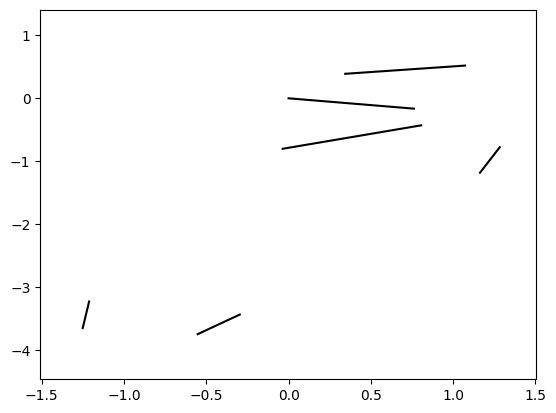

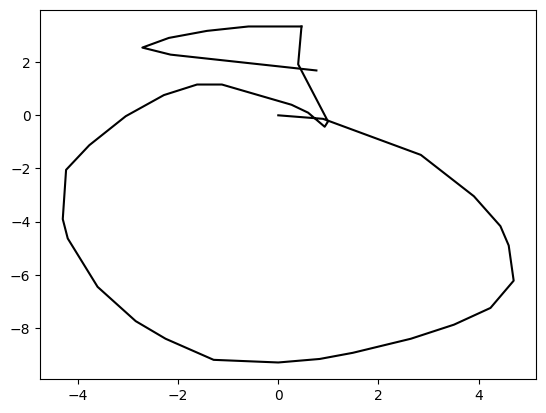

Epoch: 11, Loss: 9.17926404494851
l_kl: 4.6310 l_s: 0.8310 l_p: 5.1065
---------------------------------------------------------

Epoch: 21, Loss: 7.429932028528107
l_kl: 1.6811 l_s: 1.0076 l_p: 5.2456
---------------------------------------------------------

Epoch: 31, Loss: 7.599469774426976
l_kl: 1.2226 l_s: 1.0800 l_p: 5.6636
---------------------------------------------------------

Epoch: 41, Loss: 6.8255270066534575
l_kl: 0.2853 l_s: 1.1479 l_p: 5.4779
---------------------------------------------------------

Epoch: 51, Loss: 5.693377876467025
l_kl: 0.1804 l_s: 1.3890 l_p: 4.1781
---------------------------------------------------------

Epoch: 61, Loss: 7.1720296871584575
l_kl: 0.1654 l_s: 1.6706 l_p: 5.3856
---------------------------------------------------------

Epoch: 71, Loss: 4.324218394458671
l_kl: 0.4008 l_s: 0.4042 l_p: 3.6395
---------------------------------------------------------

Epoch: 81, Loss: 3.060726149702961
l_kl: 0.3278 l_s: 0.1056 l_p: 2.7257
----------

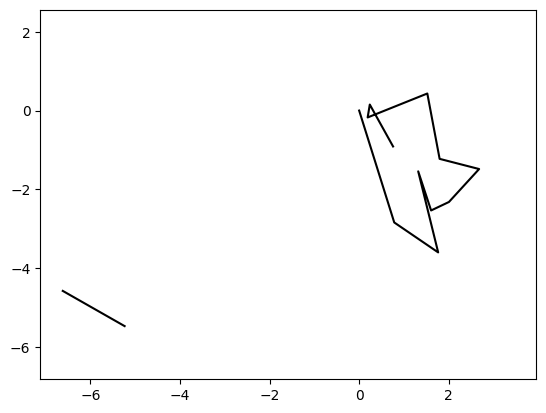

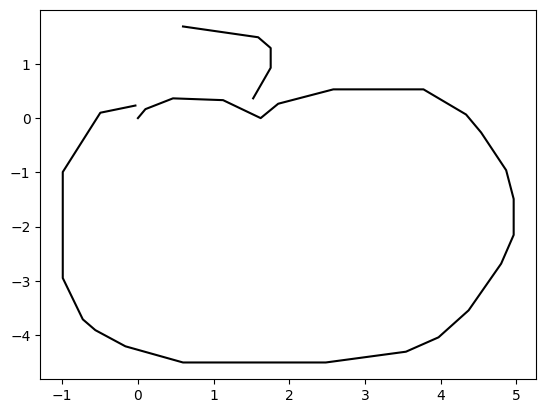

Epoch: 111, Loss: 0.8129145944955793
l_kl: 0.2332 l_s: -0.0924 l_p: 0.7420
---------------------------------------------------------

Epoch: 121, Loss: 1.6388189198442045
l_kl: 1.1259 l_s: 0.1371 l_p: 0.7136
---------------------------------------------------------

Epoch: 131, Loss: 4.937552394367673
l_kl: 1.9057 l_s: 0.1800 l_p: 3.4236
---------------------------------------------------------

Epoch: 141, Loss: 1.8137620338886764
l_kl: 0.4212 l_s: 0.0008 l_p: 1.5181
---------------------------------------------------------

Epoch: 151, Loss: 0.7261722154515051
l_kl: 0.2525 l_s: 0.0143 l_p: 0.5351
---------------------------------------------------------

Epoch: 161, Loss: 0.32674632336321807
l_kl: 0.1017 l_s: -0.2122 l_p: 0.4677
---------------------------------------------------------

Epoch: 171, Loss: 0.407812958519936
l_kl: 0.1080 l_s: 0.0039 l_p: 0.3283
---------------------------------------------------------

Epoch: 181, Loss: 0.5822339656767046
l_kl: 0.1079 l_s: -0.2876 l_p: 

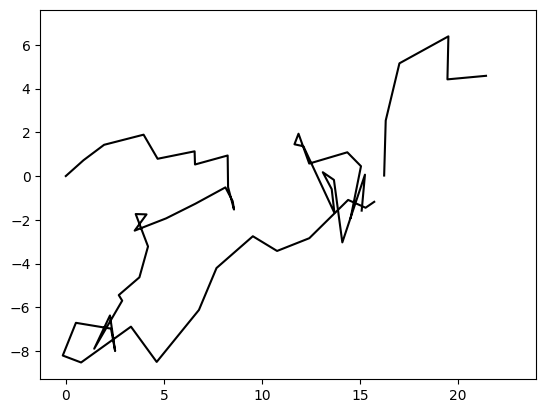

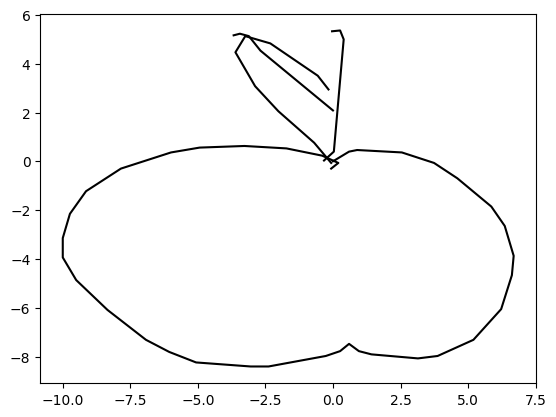

Epoch: 211, Loss: -0.5271560683840218
l_kl: 0.0839 l_s: -0.6530 l_p: 0.0671
---------------------------------------------------------

Epoch: 221, Loss: 0.16620930680640156
l_kl: 0.1509 l_s: 0.0213 l_p: 0.0393
---------------------------------------------------------

Epoch: 231, Loss: -0.5210210869853729
l_kl: 0.1239 l_s: -0.6246 l_p: 0.0168
---------------------------------------------------------

Epoch: 241, Loss: -0.7539533480814888
l_kl: 0.1078 l_s: -0.8597 l_p: 0.0303
---------------------------------------------------------

Epoch: 251, Loss: 0.3619175842129154
l_kl: 0.1364 l_s: -0.4715 l_p: 0.7380
---------------------------------------------------------

Epoch: 261, Loss: -0.7302862462319425
l_kl: 0.1381 l_s: -0.9801 l_p: 0.1531
---------------------------------------------------------

Epoch: 271, Loss: -0.45042038179495836
l_kl: 0.1330 l_s: -0.5752 l_p: 0.0317
---------------------------------------------------------

Epoch: 281, Loss: -0.7889829459795678
l_kl: 0.0827 l_s: 

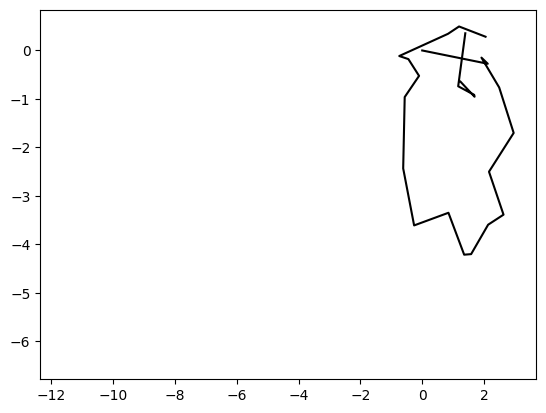

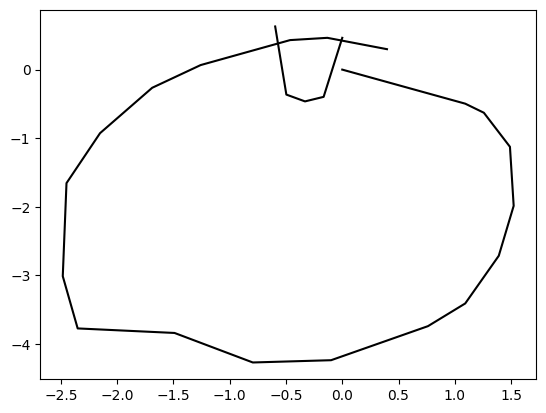

Epoch: 311, Loss: -0.26244102447825196
l_kl: 0.1146 l_s: -0.3470 l_p: 0.0043
---------------------------------------------------------

Epoch: 321, Loss: -0.9381249983758053
l_kl: 0.1221 l_s: -1.0350 l_p: 0.0114
---------------------------------------------------------

Epoch: 331, Loss: -0.7887625180067621
l_kl: 0.1276 l_s: -0.9132 l_p: 0.0351
---------------------------------------------------------

Epoch: 341, Loss: -0.9757220926996963
l_kl: 0.1103 l_s: -1.0598 l_p: 0.0069
---------------------------------------------------------

Epoch: 351, Loss: -0.8954549654437474
l_kl: 0.1149 l_s: -0.9913 l_p: 0.0154
---------------------------------------------------------

Epoch: 361, Loss: -1.1038685583029064
l_kl: 0.1142 l_s: -1.1851 l_p: 0.0013
---------------------------------------------------------

Epoch: 371, Loss: -1.0794619600341488
l_kl: 0.0942 l_s: -1.1467 l_p: 0.0014
---------------------------------------------------------

Epoch: 381, Loss: -0.5363025803973054
l_kl: 0.0968 l_s

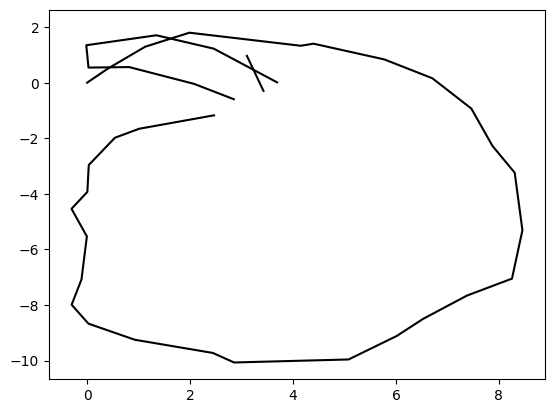

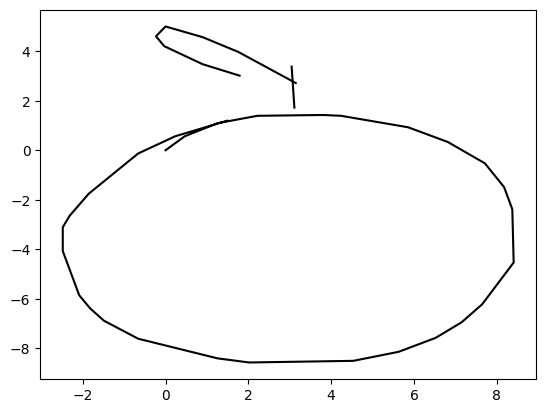

Epoch: 411, Loss: -1.4169437913924126
l_kl: 0.1627 l_s: -1.5590 l_p: 0.0282
---------------------------------------------------------

Epoch: 421, Loss: -1.2154028330913005
l_kl: 0.1633 l_s: -1.3358 l_p: 0.0061
---------------------------------------------------------

Epoch: 431, Loss: -1.2471342157711771
l_kl: 0.1160 l_s: -1.3323 l_p: 0.0040
---------------------------------------------------------

Epoch: 441, Loss: -1.5895303693091274
l_kl: 0.1286 l_s: -1.6858 l_p: 0.0063
---------------------------------------------------------

Epoch: 451, Loss: -1.662481179399644
l_kl: 0.1303 l_s: -1.7559 l_p: 0.0022
---------------------------------------------------------

Epoch: 461, Loss: -1.5413629297735487
l_kl: 0.1341 l_s: -1.6389 l_p: 0.0036
---------------------------------------------------------

Epoch: 471, Loss: -1.4969117272002768
l_kl: 0.1107 l_s: -1.5762 l_p: 0.0018
---------------------------------------------------------

Epoch: 481, Loss: -1.945798267363854
l_kl: 0.1237 l_s: -

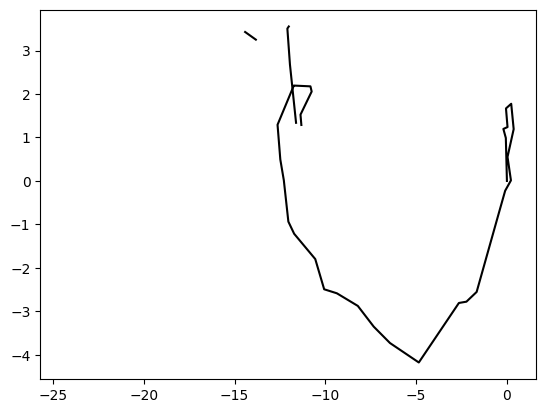

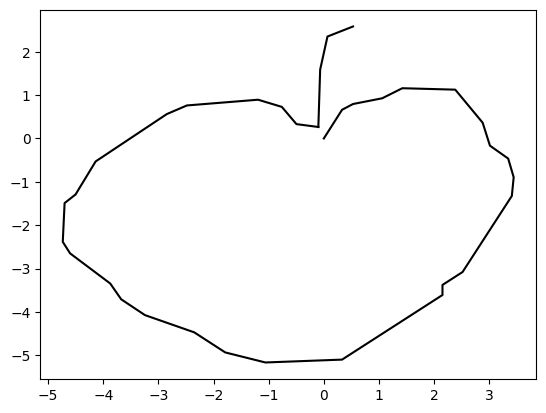

Epoch: 511, Loss: -1.1860506120977834
l_kl: 0.1242 l_s: -1.2805 l_p: 0.0075
---------------------------------------------------------

Epoch: 521, Loss: -1.4134941463502626
l_kl: 0.1002 l_s: -1.4849 l_p: 0.0013
---------------------------------------------------------

Epoch: 531, Loss: -2.7915479089677975
l_kl: 0.1113 l_s: -2.8720 l_p: 0.0026
---------------------------------------------------------

Epoch: 541, Loss: -2.408457994767628
l_kl: 0.1073 l_s: -2.4854 l_p: 0.0019
---------------------------------------------------------

Epoch: 551, Loss: -2.0005812156908367
l_kl: 0.1245 l_s: -2.0900 l_p: 0.0023
---------------------------------------------------------

Epoch: 561, Loss: -1.479928096088481
l_kl: 0.1185 l_s: -1.5708 l_p: 0.0079
---------------------------------------------------------

Epoch: 571, Loss: -0.9388865481784299
l_kl: 0.1294 l_s: -1.0337 l_p: 0.0042
---------------------------------------------------------

Epoch: 581, Loss: -2.2524801101510787
l_kl: 0.1357 l_s: -

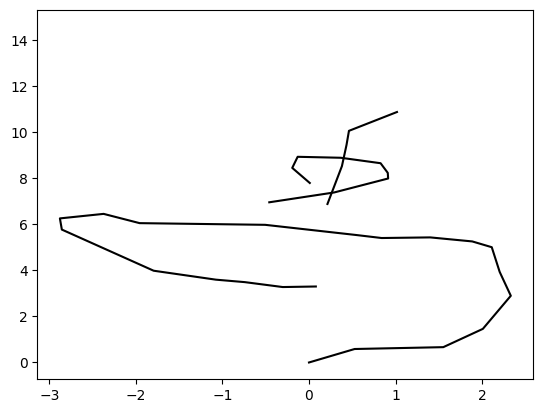

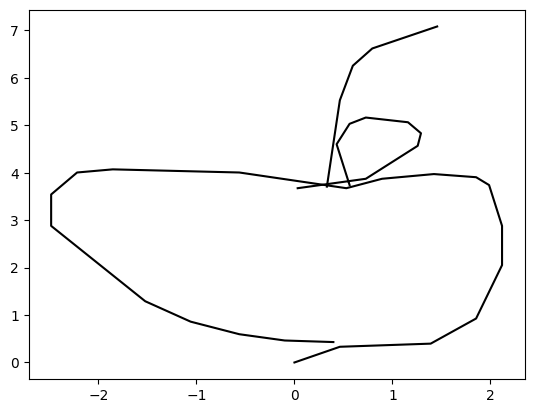

Epoch: 611, Loss: -1.407491437612474
l_kl: 0.0950 l_s: -1.4768 l_p: 0.0027
---------------------------------------------------------

Epoch: 621, Loss: -1.5951408860512588
l_kl: 0.0802 l_s: -1.6519 l_p: 0.0006
---------------------------------------------------------

Epoch: 631, Loss: -1.0861751905767172
l_kl: 0.1080 l_s: -1.1635 l_p: 0.0017
---------------------------------------------------------

Epoch: 641, Loss: -1.8350325281536586
l_kl: 0.1126 l_s: -1.9155 l_p: 0.0017
---------------------------------------------------------

Epoch: 651, Loss: -1.447870851380932
l_kl: 0.1072 l_s: -1.5254 l_p: 0.0025
---------------------------------------------------------

Epoch: 661, Loss: -1.96506080999327
l_kl: 0.0786 l_s: -2.0230 l_p: 0.0029
---------------------------------------------------------

Epoch: 671, Loss: -1.7952383550441775
l_kl: 0.0959 l_s: -1.8904 l_p: 0.0280
---------------------------------------------------------

Epoch: 681, Loss: -1.7688456382386393
l_kl: 0.1300 l_s: -1.

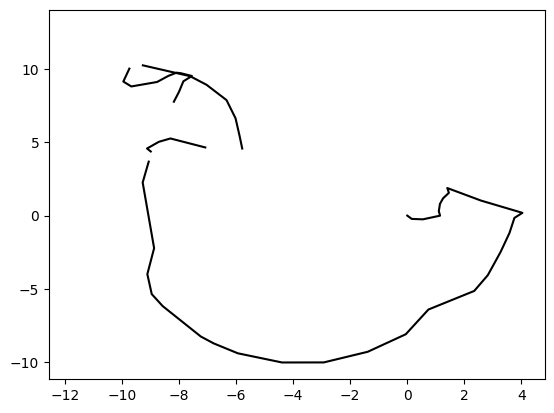

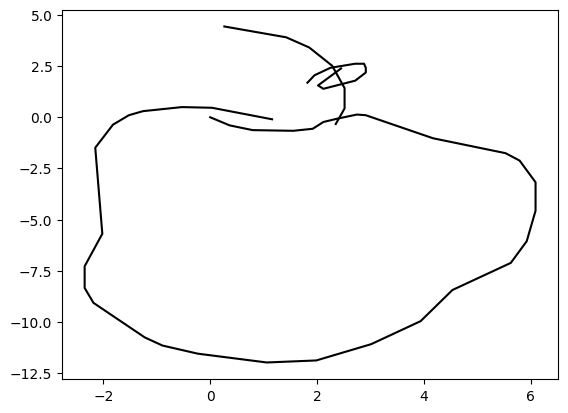

Epoch: 711, Loss: -1.985313701594111
l_kl: 0.1291 l_s: -2.0776 l_p: 0.0019
---------------------------------------------------------

Epoch: 721, Loss: -2.3604527406444857
l_kl: 0.1083 l_s: -2.4427 l_p: 0.0064
---------------------------------------------------------

Epoch: 731, Loss: -2.437516458264737
l_kl: 0.1003 l_s: -2.5113 l_p: 0.0035
---------------------------------------------------------

Epoch: 741, Loss: -2.219001109226536
l_kl: 0.1215 l_s: -2.3056 l_p: 0.0015
---------------------------------------------------------

Epoch: 751, Loss: -1.8661154411894194
l_kl: 0.1210 l_s: -1.9534 l_p: 0.0027
---------------------------------------------------------

Epoch: 761, Loss: -1.4922576699731545
l_kl: 0.0736 l_s: -1.5499 l_p: 0.0061
---------------------------------------------------------

Epoch: 771, Loss: -1.9205325209876716
l_kl: 0.1017 l_s: -1.9960 l_p: 0.0042
---------------------------------------------------------

Epoch: 781, Loss: -1.8006419747420142
l_kl: 0.2605 l_s: -2

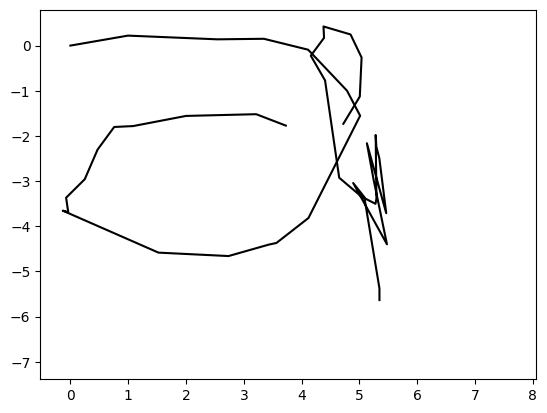

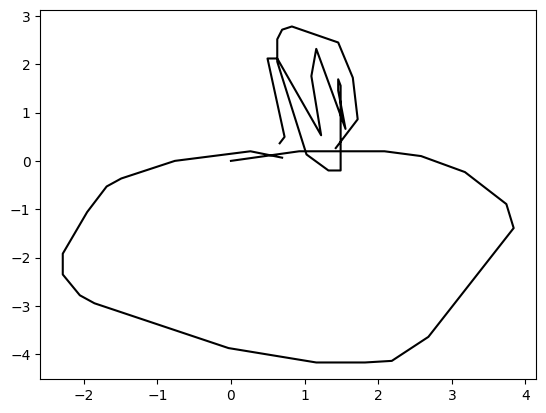

Epoch: 811, Loss: -1.931237609875173
l_kl: 0.1751 l_s: -2.0560 l_p: 0.0022
---------------------------------------------------------

Epoch: 821, Loss: -2.329748082781919
l_kl: 0.1732 l_s: -2.4556 l_p: 0.0047
---------------------------------------------------------

Epoch: 831, Loss: -2.0704048348266935
l_kl: 0.1207 l_s: -2.1585 l_p: 0.0036
---------------------------------------------------------

Epoch: 841, Loss: -2.2242952486624854
l_kl: 0.1175 l_s: -2.3142 l_p: 0.0077
---------------------------------------------------------

Epoch: 851, Loss: -2.627589582094171
l_kl: 0.1147 l_s: -2.7135 l_p: 0.0056
---------------------------------------------------------

Epoch: 861, Loss: -1.6561002368168172
l_kl: 0.1409 l_s: -1.7602 l_p: 0.0055
---------------------------------------------------------

Epoch: 871, Loss: -2.3419778909693547
l_kl: 0.1156 l_s: -2.4254 l_p: 0.0025
---------------------------------------------------------

Epoch: 881, Loss: -1.8036686471792713
l_kl: 0.1145 l_s: -1

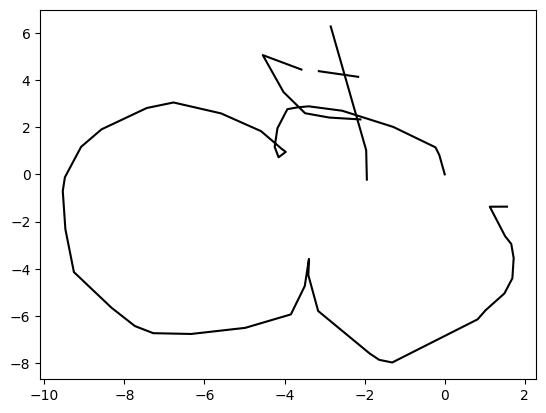

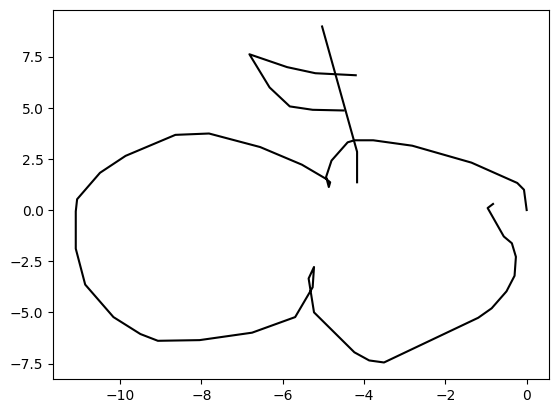

Epoch: 911, Loss: -1.577306307900278
l_kl: 0.1207 l_s: -1.6632 l_p: 0.0013
---------------------------------------------------------

Epoch: 921, Loss: -2.5151155010306856
l_kl: 0.1266 l_s: -2.6074 l_p: 0.0037
---------------------------------------------------------

Epoch: 931, Loss: -2.9967480728385296
l_kl: 0.1292 l_s: -3.0896 l_p: 0.0024
---------------------------------------------------------

Epoch: 941, Loss: -0.25184112217960747
l_kl: 0.1498 l_s: -0.3590 l_p: 0.0023
---------------------------------------------------------

Epoch: 951, Loss: -2.6348797303644598
l_kl: 0.1618 l_s: -2.7509 l_p: 0.0028
---------------------------------------------------------

Epoch: 961, Loss: -2.205173012919577
l_kl: 0.1309 l_s: -2.3009 l_p: 0.0041
---------------------------------------------------------

Epoch: 971, Loss: -2.3119114616632865
l_kl: 0.1334 l_s: -2.4070 l_p: 0.0017
---------------------------------------------------------

Epoch: 981, Loss: -2.288960057998857
l_kl: 0.1034 l_s: -

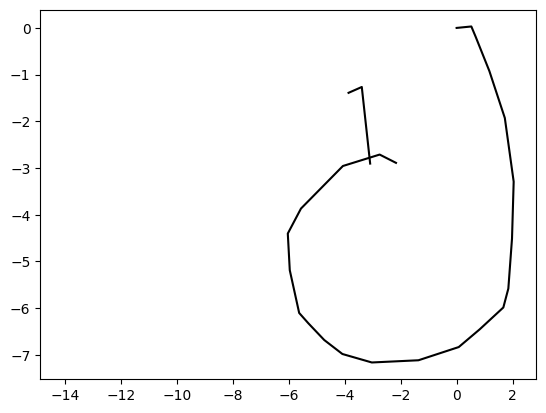

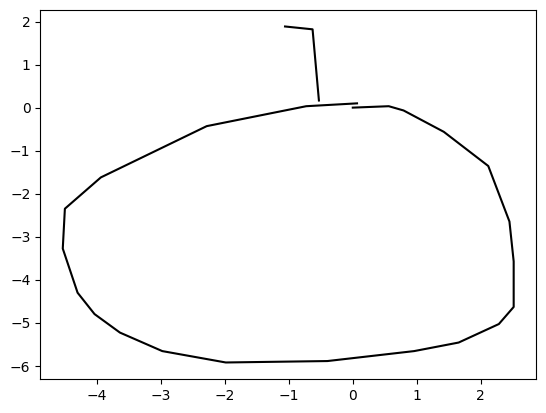

Epoch: 1011, Loss: -1.6938680603829268
l_kl: 0.2940 l_s: -1.9076 l_p: 0.0080
---------------------------------------------------------

Epoch: 1021, Loss: -1.892064579594757
l_kl: 0.1358 l_s: -1.9935 l_p: 0.0063
---------------------------------------------------------

Epoch: 1031, Loss: -2.145577641229879
l_kl: 0.1188 l_s: -2.2326 l_p: 0.0039
---------------------------------------------------------

Epoch: 1041, Loss: -2.853851239133733
l_kl: 0.1255 l_s: -2.9435 l_p: 0.0018
---------------------------------------------------------

Epoch: 1051, Loss: -2.5811663665662516
l_kl: 0.1324 l_s: -2.6815 l_p: 0.0076
---------------------------------------------------------

Epoch: 1061, Loss: -2.870339187259341
l_kl: 0.1153 l_s: -2.9547 l_p: 0.0037
---------------------------------------------------------

Epoch: 1071, Loss: -3.1912530274453963
l_kl: 0.1100 l_s: -3.2716 l_p: 0.0034
---------------------------------------------------------

Epoch: 1081, Loss: -1.836572627087464
l_kl: 0.1020 l

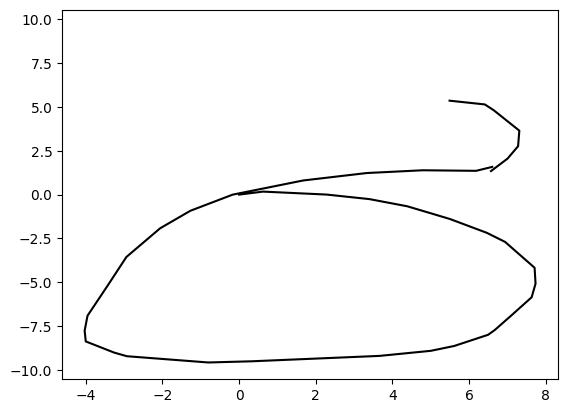

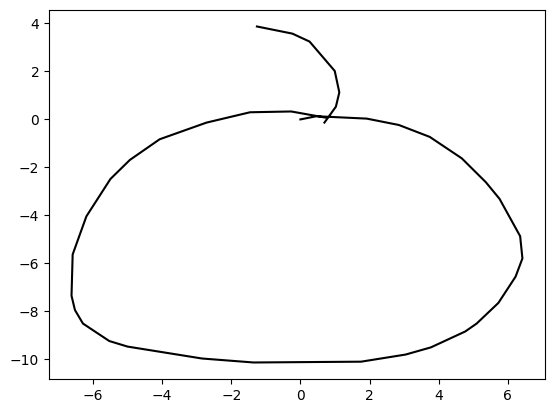

Epoch: 1111, Loss: -0.4265766350007203
l_kl: 0.1479 l_s: -0.5319 l_p: 0.0017
---------------------------------------------------------

Epoch: 1121, Loss: -2.685269681646852
l_kl: 0.1560 l_s: -2.7991 l_p: 0.0046
---------------------------------------------------------

Epoch: 1131, Loss: -2.2758025320864754
l_kl: 0.1119 l_s: -2.3570 l_p: 0.0028
---------------------------------------------------------

Epoch: 1141, Loss: -2.5401930907641304
l_kl: 0.1039 l_s: -2.6148 l_p: 0.0019
---------------------------------------------------------

Epoch: 1151, Loss: -2.38699243759441
l_kl: 0.1025 l_s: -2.4605 l_p: 0.0017
---------------------------------------------------------

Epoch: 1161, Loss: -2.2429253644758402
l_kl: 0.1376 l_s: -2.3432 l_p: 0.0039
---------------------------------------------------------

Epoch: 1171, Loss: -2.5974585821557232
l_kl: 0.1411 l_s: -2.7021 l_p: 0.0058
---------------------------------------------------------

Epoch: 1181, Loss: -1.6263356025294546
l_kl: 0.1316

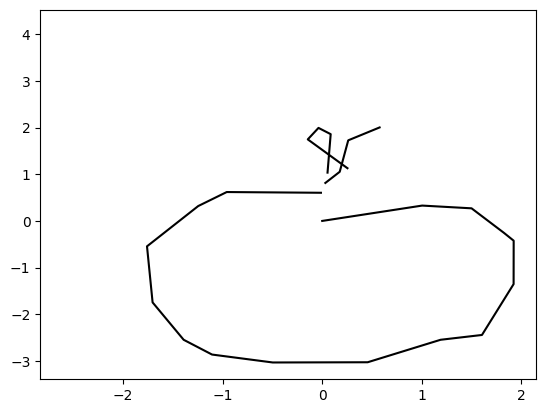

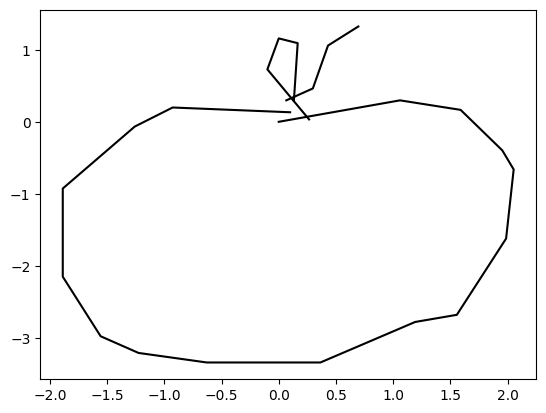

Epoch: 1211, Loss: -2.6560361843989306
l_kl: 0.0931 l_s: -2.7239 l_p: 0.0027
---------------------------------------------------------

Epoch: 1221, Loss: -2.354141912958961
l_kl: 0.0795 l_s: -2.4112 l_p: 0.0014
---------------------------------------------------------

Epoch: 1231, Loss: -1.7452612443014863
l_kl: 0.0965 l_s: -1.8161 l_p: 0.0032
---------------------------------------------------------

Epoch: 1241, Loss: -1.8651712223655532
l_kl: 0.0986 l_s: -1.9359 l_p: 0.0017
---------------------------------------------------------

Epoch: 1251, Loss: -2.0989479188045737
l_kl: 0.1065 l_s: -2.1746 l_p: 0.0011
---------------------------------------------------------

Epoch: 1261, Loss: -3.431905489873588
l_kl: 0.1013 l_s: -3.5046 l_p: 0.0018
---------------------------------------------------------

Epoch: 1271, Loss: -2.9702331708295957
l_kl: 0.0858 l_s: -3.0318 l_p: 0.0015
---------------------------------------------------------

Epoch: 1281, Loss: -1.9631427869880924
l_kl: 0.093

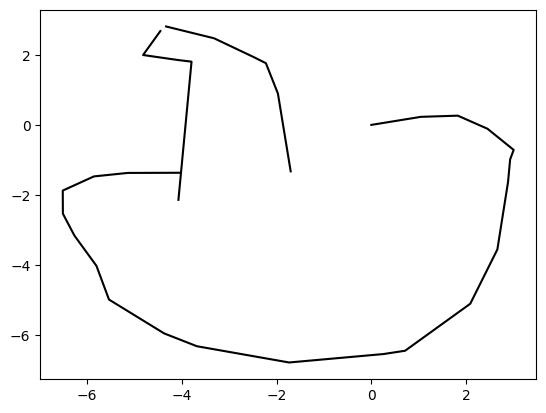

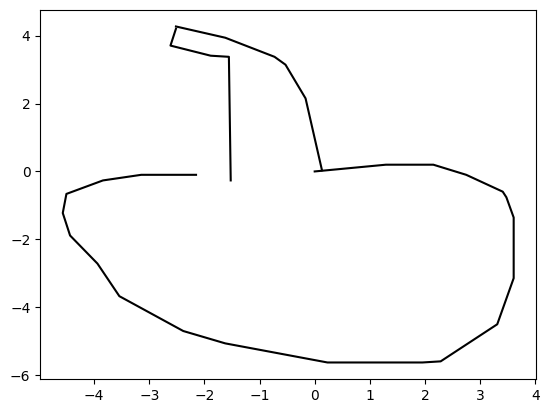

Epoch: 1311, Loss: -2.921429148089642
l_kl: 0.1461 l_s: -3.0287 l_p: 0.0050
---------------------------------------------------------

Epoch: 1321, Loss: -2.2308200000459144
l_kl: 0.1134 l_s: -2.3138 l_p: 0.0036
---------------------------------------------------------

Epoch: 1331, Loss: -1.9685629058832577
l_kl: 0.1032 l_s: -2.0425 l_p: 0.0017
---------------------------------------------------------

Epoch: 1341, Loss: -2.1732803533205542
l_kl: 0.1276 l_s: -2.2638 l_p: 0.0011
---------------------------------------------------------

Epoch: 1351, Loss: -1.9986129747714099
l_kl: 0.1541 l_s: -2.1092 l_p: 0.0028
---------------------------------------------------------

Epoch: 1361, Loss: -2.636416992008553
l_kl: 0.1388 l_s: -2.7380 l_p: 0.0044
---------------------------------------------------------

Epoch: 1371, Loss: -2.5220907085813575
l_kl: 0.1244 l_s: -2.6117 l_p: 0.0025
---------------------------------------------------------

Epoch: 1381, Loss: -3.278808458770084
l_kl: 0.1401

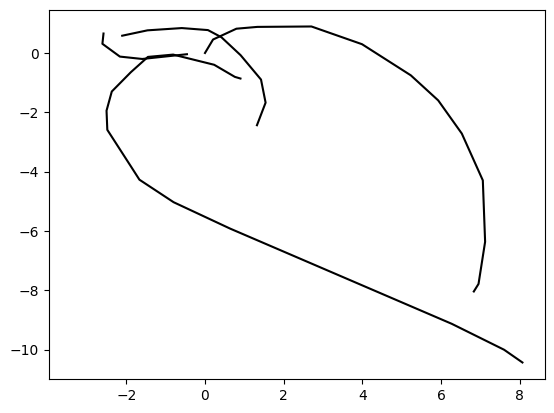

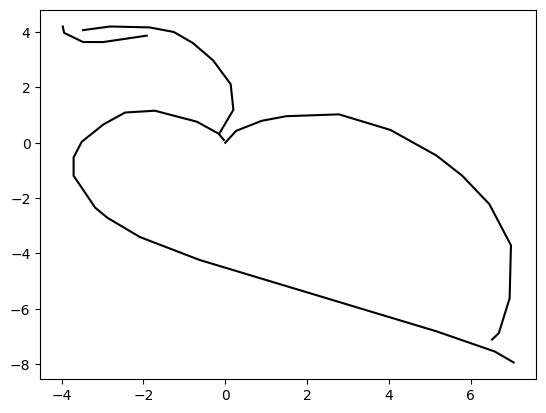

Epoch: 1411, Loss: -2.030863073793909
l_kl: 0.1709 l_s: -2.1522 l_p: 0.0017
---------------------------------------------------------

Epoch: 1421, Loss: -2.6010003421946517
l_kl: 0.1764 l_s: -2.7264 l_p: 0.0019
---------------------------------------------------------

Epoch: 1431, Loss: -2.4171814331081944
l_kl: 0.1731 l_s: -2.5399 l_p: 0.0015
---------------------------------------------------------

Epoch: 1441, Loss: -3.3581913025089714
l_kl: 0.1675 l_s: -3.4780 l_p: 0.0026
---------------------------------------------------------

Epoch: 1451, Loss: -2.2689377768824253
l_kl: 0.1301 l_s: -2.3614 l_p: 0.0014
---------------------------------------------------------

Epoch: 1461, Loss: -1.5937525626324487
l_kl: 0.1312 l_s: -1.6869 l_p: 0.0014
---------------------------------------------------------

Epoch: 1471, Loss: -2.619650234993849
l_kl: 0.1417 l_s: -2.7229 l_p: 0.0040
---------------------------------------------------------

Epoch: 1481, Loss: -2.680157559200689
l_kl: 0.1540

In [22]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr = lr)    
# weights = os.listdir("model/final") # directory does not exist on my pc atm, feel free to change
    
if pretrained and not len(os.listdir("model/final")) == 0:
    weights = os.listdir("model/final")
    loaded_state = torch.load(f"model/final/{weights[0]}", map_location=device)
    model.load_state_dict(loaded_state['model'])
    optimizer.load_state_dict(loaded_state['opt'])

train()